In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

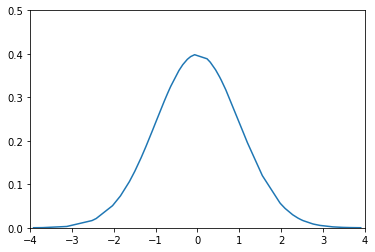

In [2]:
DRAW_SIZE = 64 # size of one input(not batch_size when train)
DRAW_X_MIN = -4
DRAW_X_MAX = 4

def gaussian(draw_points):
    MU = 0
    SIGMA = 1
    return norm.pdf(draw_points, loc=MU, scale=SIGMA)

def draw(x, y):
    plt.figure()
    plt.xlim(DRAW_X_MIN, DRAW_X_MAX)
    plt.ylim(0, 0.5)
    plt.plot(x, y)
    plt.show()

def draw_gaussian():
    x = np.random.uniform(DRAW_X_MIN, DRAW_X_MAX, size=(1, DRAW_SIZE))
    x.sort()
    y = gaussian(x)
    draw(x[0], y[0])

draw_gaussian()

In [3]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [4]:
def generator():
    G = Sequential()
    G.add(Dense(128, input_shape=(DRAW_SIZE,), activation='relu'))
    G.add(Dense(DRAW_SIZE))
    return G

In [5]:
def discriminator():
    D = Sequential()
    D.add(Dense(128, input_shape=(DRAW_SIZE,), activation='relu'))
    # sigmoid activation is good, since we need a probability
    D.add(Dense(1, activation='sigmoid'))
    return D

In [6]:
def GAN(G, D):
    model = Sequential()
    model.add(G)
    # discriminator is not trainable in GAN
    D.trainable = False
    model.add(D)
    return model

In [10]:
BATCH_SIZE = 5

def train(G, D, M):
    # 1. Train **Discriminator**
    x_batch = np.random.uniform(DRAW_X_MIN, DRAW_X_MAX, size=(BATCH_SIZE, DRAW_SIZE))
    x_batch.sort(axis=1) # it's important!!!
    rand_true_batch = gaussian(x_batch)
    gene_pred_batch = G.predict(x_batch)
    
    X = np.concatenate([rand_true_batch, gene_pred_batch])
    y = np.zeros((BATCH_SIZE * 2, 1))
    y[:BATCH_SIZE] = 0
    y[BATCH_SIZE:] = 1
    
    #G.trainable = False # it matters little
    D.trainable = True
    d_loss = D.train_on_batch(X, y)
    
    # 2. Train **GAN**
    # mainly on generator, so discriminator is not trainable
    X = np.random.uniform(DRAW_X_MIN, DRAW_X_MAX, size=(BATCH_SIZE, DRAW_SIZE))
    # Why zeros, because this is generated by generator, discriminator should give 0
    # Always negative, make generator better and better. 
    # Also, the Discriminator should grow together, as in the 1 step above of train
    y = np.zeros((BATCH_SIZE, 1))
    
    #G.trainable = True # corelate with line above
    D.trainable = False
    m_loss = M.train_on_batch(X, y)
    
    return d_loss, m_loss

In [8]:
def test_G(G):
    x = np.random.uniform(DRAW_X_MIN, DRAW_X_MAX, size=(1, DRAW_SIZE))
    x.sort(axis=1)
    y = G.predict(x)
    draw(x[0], y[0])

Epoch 1000, D loss:0.5383533239364624, M loss:1.2966452836990356


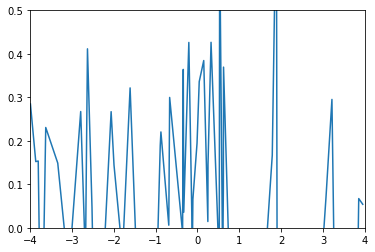

Epoch 2000, D loss:0.5130902528762817, M loss:1.0702718496322632


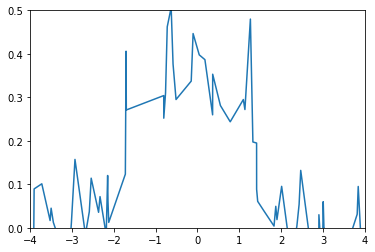

Epoch 3000, D loss:0.6217108964920044, M loss:1.001785397529602


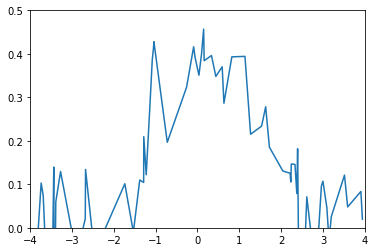

Epoch 4000, D loss:0.6810075044631958, M loss:0.8000239133834839


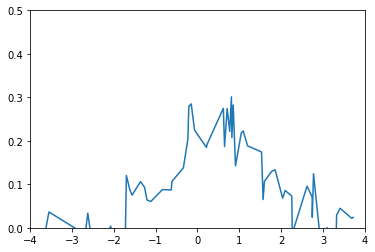

Epoch 5000, D loss:0.6891204714775085, M loss:0.7446133494377136


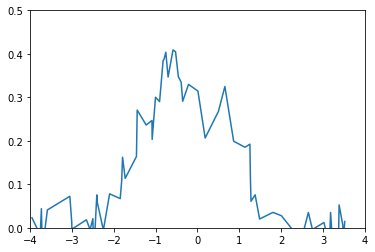

Epoch 6000, D loss:0.6717144250869751, M loss:0.7052069902420044


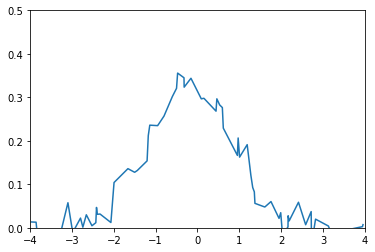

Epoch 7000, D loss:0.6992442607879639, M loss:0.6974925994873047


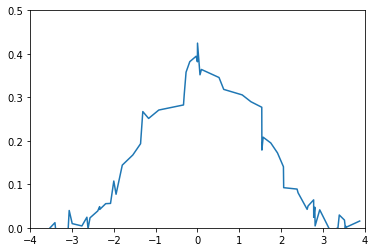

Epoch 8000, D loss:0.6919783353805542, M loss:0.6925494074821472


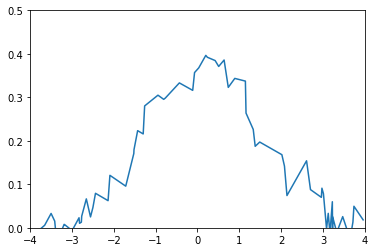

Epoch 9000, D loss:0.6992852091789246, M loss:0.6866074800491333


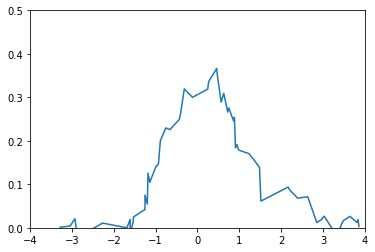

Epoch 10000, D loss:0.6962050795555115, M loss:0.6978058218955994


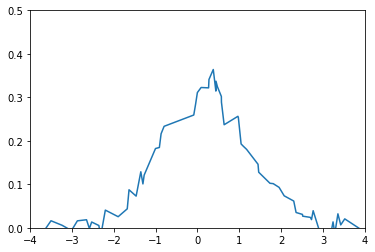

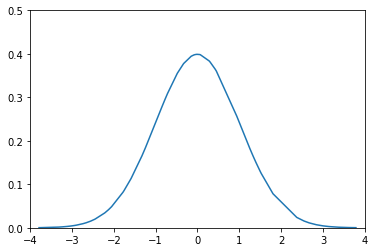

In [11]:
G = generator()
D = discriminator()
M = GAN(G, D)

M.compile(loss='binary_crossentropy', optimizer="SGD")
G.compile(loss='binary_crossentropy', optimizer="SGD")
D.trainable = True
D.compile(loss='binary_crossentropy', optimizer="SGD")

for i in range(10000):
    d_loss, m_loss = train(G, D, M)
    
    if i % 1000 == 999:
        print("Epoch {0}, D loss:{1}, M loss:{2}".format(i + 1, d_loss, m_loss))
        test_G(G)

draw_gaussian()